In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

df = pd.read_csv('../click_fraud_dataset.csv')
df.head()

,click_id,timestamp,user_id,ip_address,device_type,browser,operating_system,referrer_url,page_url,click_duration,...,mouse_movement,keystrokes_detected,ad_position,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,bot_likelihood_score,is_fraudulent
0,d875835d-3a4a-4a20-b0d1-6cddf89afc6a,2024-08-23 02:47:39,65a2f621-707b-49be-9c3e-ccac0b1d89ef,141.36.49.37,Tablet,Safari,Android,https://evans-ford.com/,http://www.turner-stewart.com/,0.29,...,111,8,Bottom,7,72,Good,0,1,0.29,0
1,a2d3f028-7790-4be1-9f75-df1357edbbdb,2025-01-30 23:23:50,135e0114-76c5-43ea-bdef-80ab537dc009,216.29.19.201,Desktop,Opera,iOS,https://pierce-ferguson.net/,http://www.rodriguez.biz/,0.64,...,452,29,Bottom,9,201,Suspicious,0,0,0.74,0
2,36d787b2-fbce-43ef-8c02-7c8746d7e3db,2025-01-21 05:41:12,a6922984-78cb-4c01-9c88-bfe3a13a0aaf,167.133.41.231,Tablet,Safari,Linux,https://www.martinez.com/,https://beck.biz/,0.42,...,431,18,Bottom,9,326,Good,0,1,0.14,0
3,01fc0078-096b-4f90-82ae-aa8085b719ac,2024-10-12 08:18:14,d30788b2-4048-4770-a4b1-a9358788818f,216.146.33.78,Tablet,Edge,macOS,https://jones-mendoza.com/,https://www.alvarado.com/,4.29,...,472,37,Side,4,33,Suspicious,0,0,0.65,0
4,0afdf2af-0b48-47d5-bfb6-e087053e1eb9,2024-04-19 14:44:35,dfc42287-6325-4344-b373-b8e61ea6e5c1,146.37.54.245,Desktop,Opera,Windows,https://www.griffith-holloway.com/,http://gonzalez.com/,2.46,...,50,2,Side,7,97,Good,0,0,0.06,0


In [35]:
# Remove IDs, timestamps, and URLs (not useful for training)
drop_cols = [
    "click_id", "timestamp", "user_id", "referrer_url", "page_url", "ad_position", "bot_likelihood_score"
]
df = df.drop(columns=drop_cols)

df.head()

,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,is_fraudulent
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,Good,0,1,0
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,Suspicious,0,0,0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,Good,0,1,0
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,Suspicious,0,0,0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,Good,0,0,0


In [36]:
import geoip2.database

city_db = "GeoLite2/GeoLite2-City.mmdb"
asn_db = "GeoLite2/GeoLite2-ASN.mmdb"

reader_city = geoip2.database.Reader(city_db)
reader_asn = geoip2.database.Reader(asn_db)

def enrich_ip(ip):
    data = {
        "ip_country": None,
        "ip_city": None,
        "ip_asn": None,
        "ip_org": None,
        "ip_is_datacenter": 0
    }
    try:
        city = reader_city.city(ip)
        asn = reader_asn.asn(ip)

        data["ip_country"] = city.country.name
        data["ip_city"] = city.city.name
        data["ip_asn"] = asn.autonomous_system_number
        data["ip_org"] = asn.autonomous_system_organization

        # crude datacenter detection
        dc_keywords = ['Amazon', 'Google', 'OVH', 'Microsoft', 'DigitalOcean', 'Hetzner', 'Linode']
        if any(k in (asn.autonomous_system_organization or "") for k in dc_keywords):
            data["ip_is_datacenter"] = 1
    except Exception:
        pass
    return pd.Series(data)

# Example use:
ip_info = enrich_ip("203.94.72.111")
print(ip_info)


ip_country                           Sri Lanka
ip_city                                Colombo
ip_asn                                    9329
ip_org              Sri Lanka Telecom Internet
ip_is_datacenter                             0
dtype: object


In [37]:
df = df.join(df['ip_address'].apply(enrich_ip))
df.head()

,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,is_fraudulent,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,Good,0,1,0,NaN,NaN,NaN,NaN,0.0
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,Suspicious,0,0,0,United States,None,174.0,COGENT-174,0.0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,Good,0,1,0,NaN,NaN,NaN,NaN,0.0
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,Suspicious,0,0,0,United States,Ashburn,31898.0,ORACLE-BMC-31898,0.0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,Good,0,0,0,NaN,NaN,NaN,NaN,0.0


In [38]:
# --- Derived behavioral features and IP risk flag (Model3) ---
for col in ['click_duration','click_frequency','scroll_depth','mouse_movement','keystrokes_detected','time_since_last_click','VPN_usage','proxy_usage','ip_is_datacenter']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

epsilon = 1e-5

df['click_intensity'] = df['click_frequency'] / (df['click_duration'] + epsilon)

df['engagement_ratio'] = (df['scroll_depth'] + df['mouse_movement']) / (df['click_duration'] + 1)

df['inactivity_ratio'] = df['time_since_last_click'] / (df['click_duration'] + 1)

df['input_activity'] = df['keystrokes_detected'] + df['mouse_movement']

if 'device_ip_reputation' in df.columns and df['device_ip_reputation'].dtype == object:
    df['ip_risk_flag'] = ((df['device_ip_reputation'].isin(['Poor','Unknown'])) | (df['ip_is_datacenter'] == 1) | (df['VPN_usage'] == 1) | (df['proxy_usage'] == 1)).astype(int)
else:
    df['ip_risk_flag'] = ((df.get('ip_is_datacenter',0) == 1) | (df.get('VPN_usage',0) == 1) | (df.get('proxy_usage',0) == 1)).astype(int)

print('Derived features added for model3')
df.head()

Derived features added for model3


,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,...,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter,click_intensity,engagement_ratio,inactivity_ratio,input_activity,ip_risk_flag
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,...,NaN,NaN,NaN,NaN,0.0,24.137099,132.558140,55.813953,119,1
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,...,United States,None,174.0,COGENT-174,0.0,14.062280,290.853659,122.560976,481,0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,...,NaN,NaN,NaN,NaN,0.0,21.428061,328.873239,229.577465,449,1
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,...,United States,Ashburn,31898.0,ORACLE-BMC-31898,0.0,0.932399,94.706994,6.238185,509,0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,...,NaN,NaN,NaN,NaN,0.0,2.845517,41.618497,28.034682,52,0


In [39]:
from user_agents import parse

def parse_user_agent(ua_str):
    try:
        ua = parse(ua_str)
        return pd.Series({
            "ua_browser": ua.browser.family,
            "ua_os": ua.os.family,
            "ua_device": ua.device.family,
            "ua_is_mobile": ua.is_mobile,
            "ua_is_tablet": ua.is_tablet,
            "ua_is_pc": ua.is_pc,
            "ua_is_bot": ua.is_bot
        })
    except Exception:
        return pd.Series({
            "ua_browser": None,
            "ua_os": None,
            "ua_device": None,
            "ua_is_mobile": False,
            "ua_is_tablet": False,
            "ua_is_pc": False,
            "ua_is_bot": False
        })

# Example:
ua_info = parse_user_agent("Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/117.0.0.0 Safari/537.36")
print(ua_info)


ua_browser       Chrome
ua_os           Windows
ua_device         Other
ua_is_mobile      False
ua_is_tablet      False
ua_is_pc           True
ua_is_bot         False
dtype: object


In [40]:
import ipaddress

def is_private_ip(ip):
    try:
        return ipaddress.ip_address(ip).is_private
    except:
        return False

# Enhanced fraud scoring using derived features
def fraud_score(row):
    score = 0

    # 1️⃣ IP-based
    if row.get("ip_is_datacenter") == 1:
        score += 3
    if is_private_ip(row.get("ip_address", "")):
        score += 2
    if row.get("VPN_usage") == 1 or row.get("proxy_usage") == 1:
        score += 2
    if row.get('ip_risk_flag', 0) == 1:
        score += 2

    # 2️⃣ Device & OS mismatch
    os = str(row.get("operating_system", "")).lower()
    browser = str(row.get("browser", "")).lower()
    device = str(row.get("device_type", "")).lower()

    if "windows" in os and "safari" in browser:
        score += 2
    if device == "mobile" and row.get("mouse_movement", 0) > 0:
        score += 1

    # 3️⃣ User-agent analysis (if parsed)
    if row.get("ua_is_bot", False):
        score += 4

    # 4️⃣ Behavior - derived features influence
    click_intensity = float(row.get("click_intensity", 0))
    if click_intensity > 10:  # threshold can be tuned
        score += 2
    elif click_intensity > 4:
        score += 1

    # Engagement ratio: low engagement (low scroll+movement relative to time) could be bot-like
    engagement_ratio = float(row.get("engagement_ratio", 0))
    if engagement_ratio < 0.5:
        score += 1

    # Inactivity bursts followed by short actions suggest automation
    inactivity_ratio = float(row.get("inactivity_ratio", 0))
    if inactivity_ratio > 100:  # tune this threshold to dataset
        score += 2
    elif inactivity_ratio > 30:
        score += 1

    # Input activity: higher input indicates human
    input_activity = float(row.get("input_activity", 0))
    if input_activity > 100:
        score -= 2  # reduce fraud score (good)
    elif input_activity > 30:
        score -= 1

    # 5️⃣ Quick clicks
    if row.get("click_duration", 10) < 1.0:
        score += 1

    # Ensure score is non-negative
    score = max(0, score)
    return score

# Apply to dataset
df["fraud_score"] = df.apply(fraud_score, axis=1)

# Decide labels
df["predicted_label"] = (df["fraud_score"] >= 4).astype(int)  # 1=fraudulent, 0=genuine

df[["ip_address", "ip_country", "device_type", "browser", "operating_system", "fraud_score", "predicted_label"]].head()

,ip_address,ip_country,device_type,browser,operating_system,fraud_score,predicted_label
0,141.36.49.37,NaN,Tablet,Safari,Android,6,1
1,216.29.19.201,United States,Desktop,Opera,iOS,3,0
2,167.133.41.231,NaN,Tablet,Safari,Linux,7,1
3,216.146.33.78,United States,Tablet,Edge,macOS,0,0
4,146.37.54.245,NaN,Desktop,Opera,Windows,0,0


In [41]:
# Convert all ASN values to string and fill NaN with "Unknown"
df["ip_asn"] = df["ip_asn"].astype(str).fillna("Unknown")

# Optional: Clean numeric-only ASNs (make them consistent like 'AS12345')
df["ip_asn"] = df["ip_asn"].apply(lambda x: f"AS{x}" if x.isdigit() else x)
df.head()


,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,...,ip_asn,ip_org,ip_is_datacenter,click_intensity,engagement_ratio,inactivity_ratio,input_activity,ip_risk_flag,fraud_score,predicted_label
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,...,nan,NaN,0.0,24.137099,132.558140,55.813953,119,1,6,1
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,...,174.0,COGENT-174,0.0,14.062280,290.853659,122.560976,481,0,3,0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,...,nan,NaN,0.0,21.428061,328.873239,229.577465,449,1,7,1
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,...,31898.0,ORACLE-BMC-31898,0.0,0.932399,94.706994,6.238185,509,0,0,0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,...,nan,NaN,0.0,2.845517,41.618497,28.034682,52,0,0,0


In [42]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
label_encoders = {}
for col in ["device_type", "browser", "operating_system", "device_ip_reputation", "ip_country", "ip_city", "ip_asn", "ip_org"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()

,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,...,ip_asn,ip_org,ip_is_datacenter,click_intensity,engagement_ratio,inactivity_ratio,input_activity,ip_risk_flag,fraud_score,predicted_label
0,141.36.49.37,2,4,0,0.29,60,111,8,7,72,...,1227,1147,0.0,24.137099,132.558140,55.813953,119,1,6,1
1,216.29.19.201,0,3,3,0.64,25,452,29,9,201,...,251,179,0.0,14.062280,290.853659,122.560976,481,0,3,0
2,167.133.41.231,2,4,1,0.42,36,431,18,9,326,...,1227,1147,0.0,21.428061,328.873239,229.577465,449,1,7,1
3,216.146.33.78,2,1,4,4.29,29,472,37,4,33,...,615,689,0.0,0.932399,94.706994,6.238185,509,0,0,0
4,146.37.54.245,0,3,2,2.46,94,50,2,7,97,...,1227,1147,0.0,2.845517,41.618497,28.034682,52,0,0,0


In [43]:
# Drop ip_address after enrichment
df = df.drop(columns=['ip_address'])
df.head()

,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,device_ip_reputation,...,ip_asn,ip_org,ip_is_datacenter,click_intensity,engagement_ratio,inactivity_ratio,input_activity,ip_risk_flag,fraud_score,predicted_label
0,2,4,0,0.29,60,111,8,7,72,1,...,1227,1147,0.0,24.137099,132.558140,55.813953,119,1,6,1
1,0,3,3,0.64,25,452,29,9,201,2,...,251,179,0.0,14.062280,290.853659,122.560976,481,0,3,0
2,2,4,1,0.42,36,431,18,9,326,1,...,1227,1147,0.0,21.428061,328.873239,229.577465,449,1,7,1
3,2,1,4,4.29,29,472,37,4,33,2,...,615,689,0.0,0.932399,94.706994,6.238185,509,0,0,0
4,0,3,2,2.46,94,50,2,7,97,1,...,1227,1147,0.0,2.845517,41.618497,28.034682,52,0,0,0


In [44]:
from sklearn.preprocessing import StandardScaler

# Define numeric columns (added derived features)
numeric_cols = ['click_duration',
                'scroll_depth',
                'mouse_movement',
                'keystrokes_detected',
                'click_frequency',
                'time_since_last_click',
                'device_ip_reputation',
                'device_type',
                'browser',
                'operating_system',
                'ip_country',
                'ip_city',
                'ip_asn',
                'ip_org',
                'VPN_usage',
                'proxy_usage',
                'ip_is_datacenter',
                # Derived features
                'click_intensity',
                'engagement_ratio',
                'inactivity_ratio',
                'input_activity',
                'ip_risk_flag']

scaler = StandardScaler()
# Fill NaNs and scale
df[numeric_cols] = scaler.fit_transform(df[numeric_cols].fillna(0))

print("Scaling completed!")

Scaling completed!


In [45]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["is_fraudulent", "predicted_label"])
y = df["is_fraudulent"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Data ready for model training!")
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Data ready for model training!
Train size: (4000, 23)
Test size: (1000, 23)


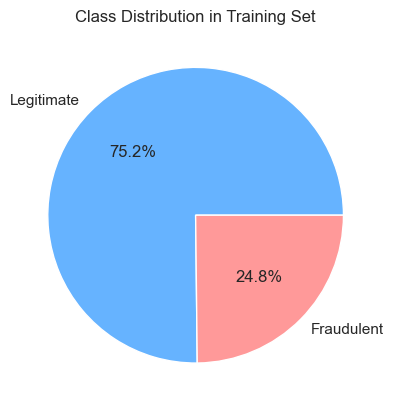

In [46]:
plt.pie(y_train.value_counts(), labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title('Class Distribution in Training Set')
plt.show()

### Anomaly Detection Model Training and Evaluation

#### Isolation Forest

In [47]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# Initialize Isolation Forest model
iso = IsolationForest(random_state=42, contamination=0.01, n_estimators=100)

# Train model
iso.fit(X_train)

# Predictions: -1 = anomaly, 1 = normal
y_pred = iso.predict(X_train)

# Convert to 0 (normal) and 1 (fraudulent) to match your dataset
y_pred_train = np.where(y_pred == -1, 1, 0)

print(classification_report(y_train, y_pred_train))


              precision    recall  f1-score   support

           0       0.75      0.99      0.85      3007
           1       0.12      0.01      0.01       993

    accuracy                           0.74      4000
   macro avg       0.44      0.50      0.43      4000
weighted avg       0.60      0.74      0.64      4000



#### One-Class SVM

In [48]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

# Initialize OneClassSVM model
oc_svm = OneClassSVM(gamma="scale", kernel="rbf", nu=0.01)

# Train model
oc_svm.fit(X_train)

# Predictions: -1 = anomaly, 1 = normal
y_pred = oc_svm.predict(X_train)

# Convert to 0 (normal) and 1 (fraudulent) to match your dataset
y_pred_train = np.where(y_pred == -1, 1, 0)

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      3007
           1       0.29      0.02      0.04       993

    accuracy                           0.74      4000
   macro avg       0.52      0.50      0.45      4000
weighted avg       0.64      0.74      0.65      4000



#### Autoencoder

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [50]:
input_dim = X_train.shape[1]
encording_dim = 16

#Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
bottleneck = Dense(encording_dim, activation='relu')(encoded)

#Decoder
decoded = Dense(16, activation='relu')(bottleneck)
decoded = Dense(32, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

#Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 23)             │           759 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,143 (12.28 KB)

 Trainable params: 3,143 (12.28 KB)

 Non-trainable params: 0 (0.00 B)

Train on normal data only

In [51]:
# Select only normal transactions for training
X_train_normal = X_train[y_train == 0]

# Train the autoencoder
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2536 - val_loss: 0.9479
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2536 - val_loss: 0.9479
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8433 - val_loss: 0.8025
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8433 - val_loss: 0.8025
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6523 - val_loss: 0.7105
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6523 - val_loss: 0.7105
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5552 - val_loss: 0.6490
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5552 - val_loss: 0.6490
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5415 - val_loss: 0.6131
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5415 - val_loss: 0.6131
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5040 - val_loss: 0.5813
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5040 - val_loss:

Compute Reconstruction Errors

In [52]:
# Get reconstruction error on training set
X_train_pred = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)

# Set threshold for anomaly detection
threshold = np.percentile(mse[y_train == 0], 90)  

print(f"Reconstruction error threshold: {threshold}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
Reconstruction error threshold: 0.26387030415452944
Reconstruction error threshold: 0.26387030415452944


Classify Anomalies

In [53]:
# Predict fraud vs normal
y_pred_train = [1 if e > threshold else 0 for e in mse]
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      3007
           1       0.27      0.11      0.16       993

    accuracy                           0.70      4000
   macro avg       0.51      0.51      0.49      4000
weighted avg       0.64      0.70      0.66      4000



#### Local Outlier Factor (LOF)

In [54]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report
import numpy as np

In [55]:
# Initialize LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)

# fit on training set (normal and fraud both included for evaluation)
lof.fit(X_train)

# Predictions: -1 = anomaly, 1 = normal
y_pred = lof.predict(X_train)

# Convert to 0 (normal) and 1 (fraudulent) to match your dataset
y_pred_train = np.where(y_pred == -1, 1, 0)

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.75      0.99      0.85      3007
           1       0.17      0.01      0.01       993

    accuracy                           0.75      4000
   macro avg       0.46      0.50      0.43      4000
weighted avg       0.61      0.75      0.65      4000



Test on Unseen Data

In [56]:
# Predictions on test set
y_pred_test = lof.predict(X_test)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

# Report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85       752
           1       0.20      0.02      0.03       248

    accuracy                           0.74      1000
   macro avg       0.48      0.50      0.44      1000
weighted avg       0.61      0.74      0.65      1000



#### Save Model

In [57]:
# Save Autoencoder Model
autoencoder.save('Ensemble_Model/Base_Models/autoencoder_model.h5')

In [58]:
# Load Model
from tensorflow.keras.models import load_model
import tensorflow as tf
loaded_autoencoder = load_model('Ensemble_Model/Base_Models/autoencoder_model.h5', custom_objects={"mse": tf.keras.losses.MeanSquaredError()}, compile=True)

Sample Inputs

In [59]:
# --- Example Input ---
example_input = {
    "device_type": "Desktop",
    "browser": "Firefox",
    "operating_system": "Windows",
    "click_duration": 3.2,
    "scroll_depth": 60,
    "mouse_movement": 120,
    "keystrokes_detected": 40,
    "click_frequency": 7,
    "time_since_last_click": 72,
    "device_ip_reputation": "Good",
    "VPN_usage": 0,
    "proxy_usage": 1,
    "ip_country": "United States",
    "ip_city": "Los Angeles",
    "ip_asn": "AS15169",
    "ip_org": "Google LLC",
    "ip_is_datacenter": 0,
    "fraud_score": 3
}

example_df = pd.DataFrame([example_input])

In [60]:
# --- Clean and handle categorical features ---
categorical_cols = [
    "device_type", "browser", "operating_system",
    "device_ip_reputation", "ip_country", "ip_city",
    "ip_asn", "ip_org"
]

# Handle unseen labels gracefully
for col in categorical_cols:
    if "Unknown" not in label_encoders[col].classes_:
        label_encoders[col].classes_ = np.append(label_encoders[col].classes_, "Unknown")

    value = example_df[col].iloc[0]
    if value not in label_encoders[col].classes_:
        example_df[col] = ["Unknown"]
    example_df[col] = label_encoders[col].transform(example_df[col])

    print(f"Encoded {col}: {example_df[col].iloc[0]}")

Encoded device_type: 0
Encoded browser: 2
Encoded operating_system: 2
Encoded device_ip_reputation: 1
Encoded ip_country: 117
Encoded ip_city: 725
Encoded ip_asn: 1228
Encoded ip_org: 1148


In [61]:
# --- Identify numeric columns ---
numeric_cols = [
    "device_type", "browser", "operating_system",
    "click_duration", "scroll_depth", "mouse_movement",
    "keystrokes_detected", "click_frequency",
    "time_since_last_click", "device_ip_reputation",
    "VPN_usage", "proxy_usage",
    "ip_country", "ip_city", "ip_asn", "ip_org", "ip_is_datacenter",
     # Derived features
     "click_intensity", "engagement_ratio", "inactivity_ratio",
    "input_activity", "ip_risk_flag", "fraud_score"
]

# Compute derived features for the example input
epsilon = 1e-5
example_df['click_duration'] = example_df['click_duration'].fillna(0)
example_df['click_frequency'] = example_df['click_frequency'].fillna(0)
example_df['scroll_depth'] = example_df['scroll_depth'].fillna(0)
example_df['mouse_movement'] = example_df['mouse_movement'].fillna(0)
example_df['keystrokes_detected'] = example_df['keystrokes_detected'].fillna(0)
example_df['time_since_last_click'] = example_df['time_since_last_click'].fillna(0)
example_df['click_intensity'] = example_df['click_frequency'] / (example_df['click_duration'] + epsilon)
example_df['engagement_ratio'] = (example_df['scroll_depth'] + example_df['mouse_movement']) / (example_df['click_duration'] + 1)
example_df['inactivity_ratio'] = example_df['time_since_last_click'] / (example_df['click_duration'] + 1)
example_df['input_activity'] = example_df['keystrokes_detected'] + example_df['mouse_movement']

if example_df['device_ip_reputation'].dtype == object:
    example_df['ip_risk_flag'] = ((example_df['device_ip_reputation'].isin(['Poor','Unknown'])) | (example_df['ip_is_datacenter'] == 1) | (example_df['VPN_usage'] == 1) | (example_df['proxy_usage'] == 1)).astype(int)
else:
    example_df['ip_risk_flag'] = ((example_df.get('ip_is_datacenter',0) == 1) | (example_df.get('VPN_usage',0) == 1) | (example_df.get('proxy_usage',0) == 1)).astype(int)


# --- Apply same scaler as training (DO NOT FIT AGAIN) ---
example_df[numeric_cols] = scaler.fit_transform(example_df[numeric_cols].fillna(0))

# Reorder columns to match training data
example_df = example_df[numeric_cols]

# --- Make prediction ---
reconstructed = loaded_autoencoder.predict(example_df)

# Compute reconstruction error (e.g., Mean Squared Error per sample)
mse = np.mean(np.power(example_df - reconstructed, 2), axis=1)

# Define threshold (use your training-set analysis)
threshold = 0.01  # Example — adjust based on training

# Predict as Fraudulent if error > threshold
is_fraud = mse > threshold

print("Reconstruction Error:", mse[0])
print("✅ Prediction:", "Fraudulent" if is_fraud[0] else "Genuine")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Reconstruction Error: 0.09149812319486608
✅ Prediction: Fraudulent
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Reconstruction Error: 0.09149812319486608
✅ Prediction: Fraudulent


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Autoencoder ROC-AUC: 0.525
Autoencoder ROC-AUC: 0.525


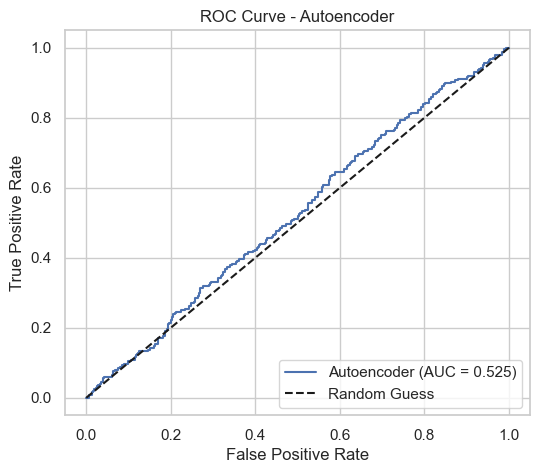

In [62]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- Get reconstruction errors ---
reconstructed = autoencoder.predict(X_test)
autoencoder_mse = np.mean(np.power(X_test.values - reconstructed, 2), axis=1)

# --- Compute ROC-AUC (only if you have true labels) ---
autoencoder_auc = roc_auc_score(y_test, autoencoder_mse)
print(f"Autoencoder ROC-AUC: {autoencoder_auc:.3f}")

# --- Plot ROC curve ---
fpr, tpr, _ = roc_curve(y_test, autoencoder_mse)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Autoencoder (AUC = {autoencoder_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Autoencoder")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
